In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

# Set device (GPU/CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Used Device: {device}")

DRIVE_ZIP_PATH="/content/drive/MyDrive/CelebA30k.zip"

!unzip -q $DRIVE_ZIP_PATH -d "/content/data"

!cp "/content/drive/MyDrive/CelebA30k.csv" "/content/"

IMG_DIR = "/content/data/CelebA30k/"
CSV_PATH = "/content/CelebA30k.csv"

NUM_EPOCHS = 10
BATCH_SIZE = 64
LR = 1e-4

Used Device: cuda:0


In [6]:
df = pd.read_csv(CSV_PATH)

df.columns


Index(['filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [7]:
# Load the dataset and split it 80/10/10 (Train/Validation/Test)
def load_and_split_data(csv_path):
    """Loads the CSV and splits it into 80/10/10 (Train/Validation/Test) DataFrames."""
    full_data = pd.read_csv(csv_path)

    # 80% Training, 20% Temporary (Validation + Test)
    train_df, temp_df = train_test_split(
        full_data,
        test_size=0.2,
        random_state=42, # For reproducibility
        stratify=full_data['Smiling'] # Preserve class balance
    )

    # Split the temporary data into 10% Validation, 10% Test
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5, # Half of 0.2
        random_state=42,
        stratify=temp_df['Smiling']
    )

    # Reset indices
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print(f"Training Set Size: {len(train_df)}")
    print(f"Validation Set Size: {len(val_df)}")
    print(f"Test Set Size: {len(test_df)}")

    return train_df, val_df, test_df

# Transformation Definitions
def get_transforms():
    """Defines transformations for Training and Validation/Test sets."""
    # Training transformations: Augmentation required by HW3 (Horizontal Flip + Color Jitter)
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5), # HW requirement
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # HW requirement
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation and Test transformations: Only resizing and normalization
    val_test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_test_transforms

# Expected Output (After loading and splitting data)
# Training Set Size: 24000
# Validation Set Size: 3000
# Test Set Size: 3000

In [8]:
# Custom Dataset Class
class CelebADataset(Dataset):
    def __init__(self, dataframe, img_dir, attribute='Smiling', transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        # CelebA labels: -1 -> No (Not Smiling), 1 -> Yes (Smiling)
        # Map to PyTorch binary labels: -1 (No) -> 0, 1 (Yes) -> 1
        self.labels = [0 if label == -1 else 1 for label in dataframe[attribute]]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)

        # Load image and convert to RGB
        # NOTE: This is where FileNotFoundError usually occurs if paths are wrong!
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create DataLoaders
def get_dataloaders(train_df, val_df, test_df, img_dir, train_transforms, val_test_transforms, batch_size=BATCH_SIZE):
    train_dataset = CelebADataset(train_df, img_dir, transform=train_transforms)
    val_dataset = CelebADataset(val_df, img_dir, transform=val_test_transforms)
    test_dataset = CelebADataset(test_df, img_dir, transform=val_test_transforms)

    # Use pin_memory=True for faster transfer to GPU
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

In [9]:
def create_vgg16_binary(mode="frozen"):
    """
    Loads the pretrained VGG-16, modifies the classifier for binary output,
    and freezes layers according to the specified fine-tuning mode.

    mode: "frozen" (all conv layers frozen) or "finetune" (last conv block unfrozen)
    """
    # Load pretrained VGG16 model
    vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # Initially freeze all VGG feature layers (Transfer Learning setup)
    for param in vgg16.features.parameters():
        param.requires_grad = False

    # Modify the Classifier Head for binary output (1 output neuron for BCEWithLogitsLoss)
    num_features = vgg16.classifier[6].in_features
    vgg16.classifier[6] = nn.Linear(num_features, 1)

    # Fine-Tuning Strategy
    if mode == "frozen":
        # Strategy 1: "Frozen" (Only the new classifier head is trained)
        print("Model: Fully Frozen Convolutional Layers.")

    elif mode == "finetune":
        # Strategy 2: "Fine-Tuning" (Unfreeze the last convolutional block and train it)
        # The last conv block layers are typically indices 24 to 30 in VGG16's features list.
        for i, layer in enumerate(vgg16.features):
            if i >= 24: # Layers belonging to the last block
                for param in layer.parameters():
                    param.requires_grad = True

        print("Model: Last Convolutional Block + Classifier Fine-Tuning.")

    else:
        raise ValueError("Mode must be 'frozen' or 'finetune'.")

    return vgg16.to(device)

In [10]:
def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=LR):
    """Trains the model and tracks the best model based on validation accuracy."""

    # Loss function (Binary Cross-Entropy Loss with Logits for stability)
    criterion = nn.BCEWithLogitsLoss()

    # Optimizer: Only optimize parameters that require gradient (i.e., unfrozen layers)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_wts = model.state_dict()
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float() # Labels must be float for BCEWithLogitsLoss

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        # --- Validation Phase ---
        model.eval()
        running_vloss = 0.0
        running_vcorrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                running_vloss += loss.item() * inputs.size(0)

                # Calculate predictions (Sigmoid > 0.5)
                preds = (torch.sigmoid(outputs) > 0.5).long()
                running_vcorrects += torch.sum(preds == labels.long()).item()

        epoch_val_loss = running_vloss / len(val_loader.dataset)
        epoch_val_acc = running_vcorrects / len(val_loader.dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Expected Output per Epoch
        print(f"Train Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f} | Validation Accuracy: {epoch_val_acc:.4f}")

        # Save the best model weights
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = model.state_dict()

    time_elapsed = time.time() - start_time
    # Expected Output at the end of training
    print(f"\nTraining Complete. Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history, best_val_acc, time_elapsed

In [11]:
# --- 6.1. Data Preparation ---

train_df, val_df, test_df = load_and_split_data(CSV_PATH)
train_transforms, val_test_transforms = get_transforms()
train_loader, val_loader, test_loader = get_dataloaders(
    train_df, val_df, test_df, IMG_DIR, train_transforms, val_test_transforms
)

# --- 6.2. Strategy 1: Frozen ---

print("\n\n*** STRATEGY 1: FULLY FROZEN ***")
model_frozen = create_vgg16_binary(mode="frozen")
(
    model_frozen_best,
    hist_frozen,
    best_val_acc_frozen,
    time_frozen
) = train_model(model_frozen, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=LR)


# --- 6.3. Strategy 2: Fine-Tuning ---

print("\n\n*** STRATEGY 2: LAST CONVOLUTIONAL BLOCK FINE-TUNING ***")
# Create a new model instance
model_finetune = create_vgg16_binary(mode="finetune")
# Use a lower learning rate for fine-tuning
LR_FINETUNE = 1e-5
(
    model_finetune_best,
    hist_finetune,
    best_val_acc_finetune,
    time_finetune
) = train_model(model_finetune, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=LR_FINETUNE)


# --- 6.4. Selecting the Best Model ---

if best_val_acc_frozen >= best_val_acc_finetune:
    best_model = model_frozen_best
    best_history = hist_frozen
    strategy_name = "Fully Frozen"
else:
    best_model = model_finetune_best
    best_history = hist_finetune
    strategy_name = "Last Block Fine-Tuning"

# Expected Final Output
# *** Best Performing Strategy: Fully Frozen *** (or Last Block Fine-Tuning)

Training Set Size: 24000
Validation Set Size: 3000
Test Set Size: 3000


*** STRATEGY 1: FULLY FROZEN ***
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 228MB/s]


Model: Fully Frozen Convolutional Layers.

Epoch 1/10
----------
Train Loss: 0.4337 | Validation Loss: 0.3778 | Validation Accuracy: 0.8213

Epoch 2/10
----------
Train Loss: 0.3335 | Validation Loss: 0.3502 | Validation Accuracy: 0.8353

Epoch 3/10
----------
Train Loss: 0.2985 | Validation Loss: 0.3329 | Validation Accuracy: 0.8460

Epoch 4/10
----------
Train Loss: 0.2650 | Validation Loss: 0.3470 | Validation Accuracy: 0.8460

Epoch 5/10
----------
Train Loss: 0.2352 | Validation Loss: 0.3913 | Validation Accuracy: 0.8427

Epoch 6/10
----------
Train Loss: 0.2125 | Validation Loss: 0.3473 | Validation Accuracy: 0.8490

Epoch 7/10
----------
Train Loss: 0.1900 | Validation Loss: 0.3605 | Validation Accuracy: 0.8533

Epoch 8/10
----------
Train Loss: 0.1649 | Validation Loss: 0.3702 | Validation Accuracy: 0.8520

Epoch 9/10
----------
Train Loss: 0.1471 | Validation Loss: 0.3914 | Validation Accuracy: 0.8523

Epoch 10/10
----------
Train Loss: 0.1300 | Validation Loss: 0.4125 | Valid


--- Test Set (Last Block Fine-Tuning) Results ---
Accuracy: 0.9060
Precision: 0.9023
Recall: 0.8997
F1 Score: 0.9010


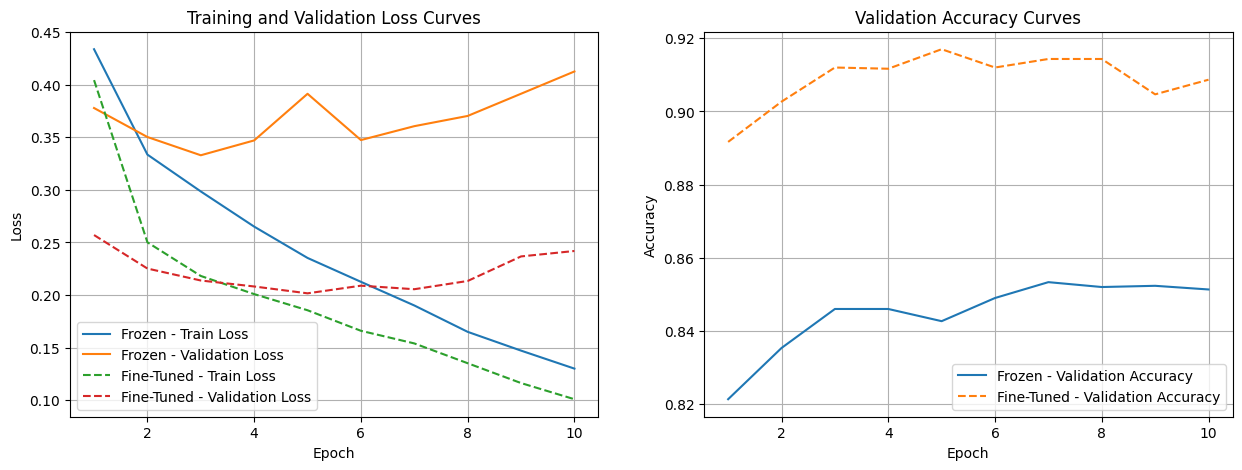

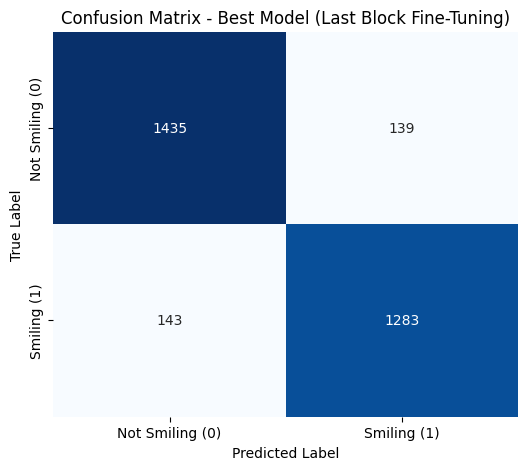


Correctly Classified Samples (T: True, P: Predicted):


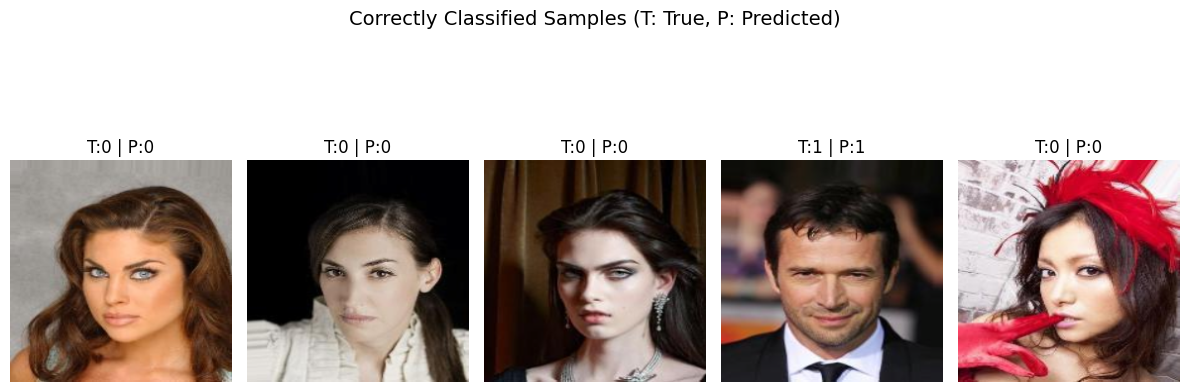


Incorrectly Classified Samples (T: True, P: Predicted):


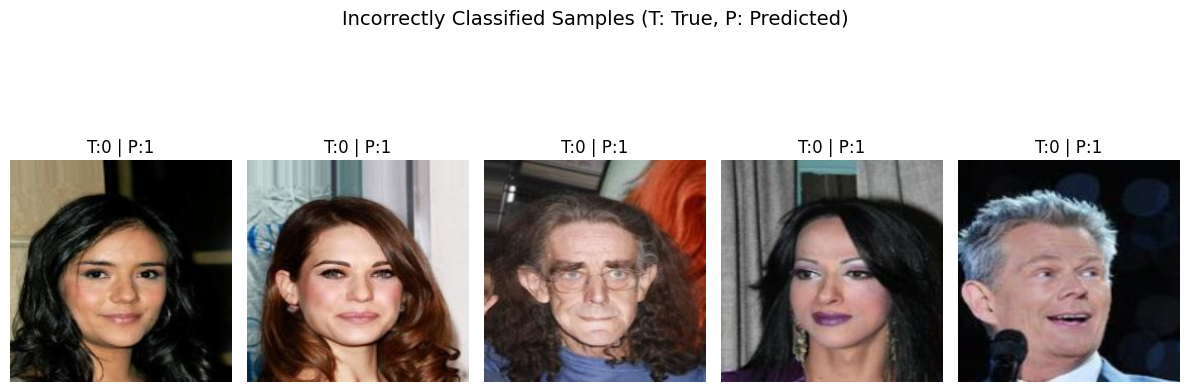

In [12]:
# --- 7.1. Test Set Evaluation ---

def evaluate_model(model, test_loader, description="Test Set"):
    """Evaluates the model on the test set and returns metrics."""
    model.eval()
    true_labels = []
    pred_probs = []
    image_tensors = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)

            outputs = model(inputs).squeeze()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()

            true_labels.extend(labels.tolist())
            pred_probs.extend(preds.cpu().tolist())
            image_tensors.extend(inputs.cpu())

    # Metrics
    accuracy = accuracy_score(true_labels, pred_probs)
    precision = precision_score(true_labels, pred_probs)
    recall = recall_score(true_labels, pred_probs)
    f1 = f1_score(true_labels, pred_probs)
    cm = confusion_matrix(true_labels, pred_probs)

    print(f"\n--- {description} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return true_labels, pred_probs, image_tensors, cm, accuracy

# Evaluate the best model on the test set
true_labels, pred_labels, image_tensors, cm_best, test_acc = evaluate_model(
    best_model, test_loader, f"Test Set ({strategy_name})"
)


# --- 7.2. Visualization of Results ---

# 1. Loss Curves Plot
def plot_history(hist_frozen, hist_finetune):
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist_frozen['train_loss'], label='Frozen - Train Loss')
    plt.plot(epochs, hist_frozen['val_loss'], label='Frozen - Validation Loss')
    plt.plot(epochs, hist_finetune['train_loss'], label='Fine-Tuned - Train Loss', linestyle='--')
    plt.plot(epochs, hist_finetune['val_loss'], label='Fine-Tuned - Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist_frozen['val_acc'], label='Frozen - Validation Accuracy')
    plt.plot(epochs, hist_finetune['val_acc'], label='Fine-Tuned - Validation Accuracy', linestyle='--')
    plt.title('Validation Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(hist_frozen, hist_finetune)


# 2. Confusion Matrix Plot
def plot_confusion_matrix(cm, strategy):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Smiling (0)', 'Smiling (1)'],
                yticklabels=['Not Smiling (0)', 'Smiling (1)'])
    plt.title(f'Confusion Matrix - Best Model ({strategy})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(cm_best, strategy_name)


# 3. Sample Classification Display
import random

def show_samples(indices, true_labels, pred_labels, image_tensors, title):
    print(f"\n{title}:")
    plt.figure(figsize=(12, 5))

    # Select up to 5 random samples
    if len(indices) > 5:
        sample_indices = random.sample(indices, 5)
    else:
        sample_indices = indices

    for i, idx in enumerate(sample_indices):
        img_tensor = image_tensors[idx]
        label = true_labels[idx]
        pred = pred_labels[idx]

        # Denormalize the image tensor for display
        img = img_tensor.clone().numpy().transpose(1, 2, 0)
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)

        plt.subplot(1, len(sample_indices), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"T:{label} | P:{pred}") # T: True, P: Predicted

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Find Correct and Incorrect Indices
correct_indices = [i for i in range(len(true_labels)) if true_labels[i] == pred_labels[i]]
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != pred_labels[i]]

# Display samples
show_samples(correct_indices, true_labels, pred_labels, image_tensors, "Correctly Classified Samples (T: True, P: Predicted)")
show_samples(incorrect_indices, true_labels, pred_labels, image_tensors, "Incorrectly Classified Samples (T: True, P: Predicted)")